In [7]:
!pip install opencv-python
!pip install tqdm
!apt-get update
!apt-get install -y libgl1

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:4 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [48.5 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4763 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [56.4 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3404 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1566 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4917 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1262 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports/main amd64 Pack

In [8]:
import numpy as np
import cv2
import random
from tqdm import tqdm


In [195]:
import numpy as np
import cv2
import random

# 常量
IMAGE_SIZE = 64
MAX_RADIUS = 8
FORCE_PROBABILITY = 0.5
FORCE_MAGNITUDE = 10.0
FRICTION_COEFF = 0.01  # 每子步减速 1%

def generate_ball_frame(pos, radius):
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
    center = (int(pos[0]), int(pos[1]))
    cv2.circle(img, center, int(radius), 255, -1)
    return img

def resolve_ball_collision(pos1, pos2, v1, v2, r1, r2):
    """
    处理两个圆形球体的弹性碰撞，质量 ∝ 半径²，沿着碰撞法线更新速度分量。
    """
    delta_pos = pos1 - pos2
    dist = np.linalg.norm(delta_pos)
    if dist == 0:
        # 防止除以 0，随机分一个方向
        normal = np.random.randn(2)
        normal /= np.linalg.norm(normal)
    else:
        normal = delta_pos / dist

    # 相对速度在法线方向上的分量
    rel_vel = v1 - v2
    vel_along_normal = np.dot(rel_vel, normal)

    if vel_along_normal >= 0:
        # 已经分离就不处理
        return v1, v2

    # 质量按面积估计
    m1 = r1 ** 2
    m2 = r2 ** 2

    # 计算冲量
    impulse = (2 * vel_along_normal) / (1/m1 + 1/m2)

    # 更新速度（弹性碰撞公式）
    v1_new = v1 - (impulse / m1) * normal
    v2_new = v2 + (impulse / m2) * normal

    return v1_new, v2_new


def generate_non_overlapping_positions(radii, image_size, max_attempts=1000):
    positions = []
    for i in range(len(radii)):
        for _ in range(max_attempts):
            candidate = np.random.uniform(radii[i], image_size - radii[i], size=2)
            if all(np.linalg.norm(candidate - p) >= (radii[i] + radii[j]) for j, p in enumerate(positions)):
                positions.append(candidate)
                break
        else:
            raise RuntimeError(f"无法为球 {i} 找到非重叠位置")
    return np.array(positions)

def simulate_ball_motion(
    num_frames, num_balls, substeps=10, continue_prob=0.3
):
    # Generate ball properties
    radii = np.random.randint(3, MAX_RADIUS + 1, size=num_balls)
    positions = generate_non_overlapping_positions(radii, IMAGE_SIZE)
    velocities = np.random.uniform(-4, 4, size=(num_balls, 2))

    # Schedule for force application: at most one force per ball, with potential continuation
    force_schedule = {}
    for i in range(num_balls):
        if random.random() < FORCE_PROBABILITY:
            start_frame = random.randint(0, num_frames - 1)
            angle = np.random.uniform(0, 2 * np.pi)
            magnitude = np.random.uniform(0, FORCE_MAGNITUDE)
            direction = magnitude * np.array([np.cos(angle), np.sin(angle)])
            force_schedule[i] = {
                "start": start_frame,
                "vector": direction,
                "active": True
            }

    frames = []

    for frame_idx in range(num_frames):
        # Apply external force if scheduled and active
        for i in range(num_balls):
            if i in force_schedule:
                fs = force_schedule[i]
                if frame_idx >= fs["start"] and fs["active"]:
                    mass = radii[i] ** 2
                    velocities[i] += fs["vector"] / mass

                    # Randomly determine whether to continue applying force
                    if random.random() > continue_prob:
                        fs["active"] = False

        # Substep integration with friction and collision resolution
        for _ in range(substeps):
            dt = 1.0 / substeps
            velocities *= (1 - FRICTION_COEFF)  # Apply friction
            positions += velocities * dt       # Update position

            # Handle collisions between balls
            for i in range(num_balls):
                for j in range(i + 1, num_balls):
                    delta = positions[i] - positions[j]
                    dist = np.linalg.norm(delta)
                    min_dist = radii[i] + radii[j]

                    if dist < min_dist:
                        rel_vel = velocities[i] - velocities[j]

                        if dist == 0:
                            direction = np.random.randn(2)
                            direction /= np.linalg.norm(direction)
                            dist = 1e-6
                        else:
                            direction = delta / dist

                        # Position correction
                        overlap = min_dist - dist
                        correction = 0.5 * overlap * direction
                        positions[i] += correction
                        positions[j] -= correction

                        # Velocity update using elastic collision
                        velocities[i], velocities[j] = resolve_ball_collision(
                            positions[i], positions[j],
                            velocities[i], velocities[j],
                            radii[i], radii[j]
                        )

        # Render the current frame
        frame = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
        for i in range(num_balls):
            frame += generate_ball_frame(positions[i], radii[i])
        frames.append(np.clip(frame, 0, 255))

    return np.stack(frames), force_schedule


In [196]:

def create_dataset(dataset_size, save_path="moving_balls_dataset.npy"):
    """Generate a dataset of ball motion sequences and save to disk."""
    all_sequences = []
    for _ in tqdm(range(dataset_size), desc="Generating dataset"):
        sequence,force_schedule =  simulate_ball_motion(num_frames=20,num_balls=2,substeps=10,continue_prob=0.4)
        all_sequences.append(sequence)
    all_sequences = np.array(all_sequences, dtype=np.uint8)
    np.save(save_path, all_sequences)
    print(f"Saved dataset to {save_path}, shape = {all_sequences.shape}")


In [202]:

def create_dataset_3balls(dataset_size, save_path="moving_balls_dataset_3balls.npy"):
    """Generate a dataset of ball motion sequences and save to disk."""
    all_sequences = []
    for _ in tqdm(range(dataset_size), desc="Generating dataset"):
        sequence,force_schedule =  simulate_ball_motion(num_frames=20,num_balls=3,substeps=10,continue_prob=0.4)
        all_sequences.append(sequence)
    all_sequences = np.array(all_sequences, dtype=np.uint8)
    np.save(save_path, all_sequences)
    print(f"Saved dataset to {save_path}, shape = {all_sequences.shape}")


In [ ]:


if __name__ == "__main__":
    create_dataset(DATASET_SIZE)

Generating dataset: 100%|██████████| 2000/2000 [00:01<00:00, 1100.29it/s]


Saved dataset to moving_balls_dataset.npy, shape = (2000, 20, 64, 64)


In [203]:


if __name__ == "__main__":
    create_dataset_3balls(DATASET_SIZE)

Generating dataset: 100%|██████████| 2000/2000 [00:03<00:00, 578.49it/s]


Saved dataset to moving_balls_dataset_3balls.npy, shape = (2000, 20, 64, 64)


In [204]:
fpath= f"{os.getcwd()}/moving_balls_dataset.npy"
dataset = np.load(fpath)

In [206]:
fpath3= f"{os.getcwd()}/moving_balls_dataset_3balls.npy"
dataset_3balls = np.load(fpath3)

Displaying frames for example 16.


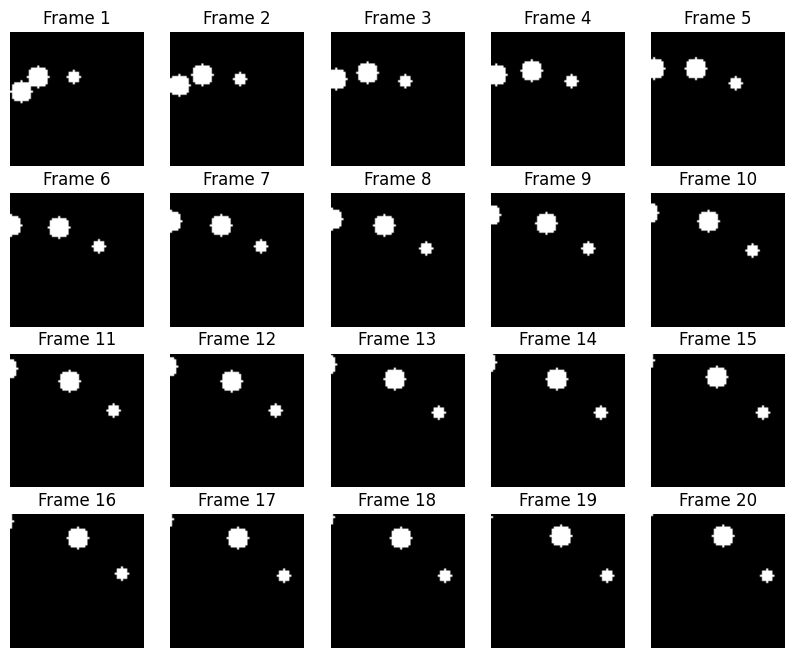

In [207]:
import matplotlib.pyplot as plt
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
#data_choice = np.random.choice(range(len(dataset)), size=1)[0]
data_choice = 16
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(dataset_3balls[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from matplotlib.animation import PillowWriter

# 加载数据集
dataset = np.load("moving_balls_dataset.npy")  # shape: (N, 20, 64, 64)
output_dir = "gif_outputs"
os.makedirs(output_dir, exist_ok=True)

# 指定想保存的样本索引（可改为 range(len(dataset)) 保存全部）
sample_indices = range(25,2000)

for idx in sample_indices:
    frames = dataset[idx]
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(frames[0], cmap="gray", animated=True)
    ax.axis("off")
    ax.set_title(f"Sample {idx}")

    def update(frame_idx):
        im.set_array(frames[frame_idx])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

    # ✅ 使用 PillowWriter 保存为 GIF
    gif_path = os.path.join(output_dir, f"sample_{idx}.gif")
    writer = PillowWriter(fps=10)
    ani.save(gif_path, writer=writer)
    plt.close(fig)

    print(f"✅ Saved GIF: {gif_path}")


✅ Saved GIF: gif_outputs/sample_25.gif
✅ Saved GIF: gif_outputs/sample_26.gif
✅ Saved GIF: gif_outputs/sample_27.gif
✅ Saved GIF: gif_outputs/sample_28.gif
✅ Saved GIF: gif_outputs/sample_29.gif
✅ Saved GIF: gif_outputs/sample_30.gif
✅ Saved GIF: gif_outputs/sample_31.gif
✅ Saved GIF: gif_outputs/sample_32.gif
✅ Saved GIF: gif_outputs/sample_33.gif
✅ Saved GIF: gif_outputs/sample_34.gif
✅ Saved GIF: gif_outputs/sample_35.gif
✅ Saved GIF: gif_outputs/sample_36.gif
✅ Saved GIF: gif_outputs/sample_37.gif
✅ Saved GIF: gif_outputs/sample_38.gif
✅ Saved GIF: gif_outputs/sample_39.gif
✅ Saved GIF: gif_outputs/sample_40.gif
✅ Saved GIF: gif_outputs/sample_41.gif
✅ Saved GIF: gif_outputs/sample_42.gif
✅ Saved GIF: gif_outputs/sample_43.gif
✅ Saved GIF: gif_outputs/sample_44.gif
✅ Saved GIF: gif_outputs/sample_45.gif
✅ Saved GIF: gif_outputs/sample_46.gif
✅ Saved GIF: gif_outputs/sample_47.gif
✅ Saved GIF: gif_outputs/sample_48.gif
✅ Saved GIF: gif_outputs/sample_49.gif
✅ Saved GIF: gif_outputs/

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from matplotlib.animation import PillowWriter

# 加载数据集
dataset_3balls = np.load("moving_balls_dataset_3balls.npy")  # shape: (N, 20, 64, 64)
output_dir = "gif_outputs_3balls"
os.makedirs(output_dir, exist_ok=True)

# 指定想保存的样本索引（可改为 range(len(dataset)) 保存全部）
sample_indices = range(25)

for idx in sample_indices:
    frames = dataset_3balls[idx]
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(frames[0], cmap="gray", animated=True)
    ax.axis("off")
    ax.set_title(f"Sample {idx}")

    def update(frame_idx):
        im.set_array(frames[frame_idx])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

    # ✅ 使用 PillowWriter 保存为 GIF
    gif_path = os.path.join(output_dir, f"sample_{idx}.gif")
    writer = PillowWriter(fps=10)
    ani.save(gif_path, writer=writer)
    plt.close(fig)

    print(f"✅ Saved GIF: {gif_path}")


✅ Saved GIF: gif_outputs_3balls/sample_0.gif
✅ Saved GIF: gif_outputs_3balls/sample_1.gif
✅ Saved GIF: gif_outputs_3balls/sample_2.gif
✅ Saved GIF: gif_outputs_3balls/sample_3.gif
✅ Saved GIF: gif_outputs_3balls/sample_4.gif
✅ Saved GIF: gif_outputs_3balls/sample_5.gif
✅ Saved GIF: gif_outputs_3balls/sample_6.gif
✅ Saved GIF: gif_outputs_3balls/sample_7.gif
✅ Saved GIF: gif_outputs_3balls/sample_8.gif
✅ Saved GIF: gif_outputs_3balls/sample_9.gif
✅ Saved GIF: gif_outputs_3balls/sample_10.gif
✅ Saved GIF: gif_outputs_3balls/sample_11.gif
✅ Saved GIF: gif_outputs_3balls/sample_12.gif
✅ Saved GIF: gif_outputs_3balls/sample_13.gif
✅ Saved GIF: gif_outputs_3balls/sample_14.gif
✅ Saved GIF: gif_outputs_3balls/sample_15.gif
✅ Saved GIF: gif_outputs_3balls/sample_16.gif
✅ Saved GIF: gif_outputs_3balls/sample_17.gif
✅ Saved GIF: gif_outputs_3balls/sample_18.gif
✅ Saved GIF: gif_outputs_3balls/sample_19.gif
✅ Saved GIF: gif_outputs_3balls/sample_20.gif
✅ Saved GIF: gif_outputs_3balls/sample_21.gi

In [44]:
import numpy as np

# 加载整个数据集
dataset = np.load("moving_balls_dataset.npy")

# 保存你想检查的样本（比如索引 1）
np.save("suspect_sample_9.npy", dataset[9])
